## Outline
#### Ensure columns are formatted correctly
#### Create Features
#### Separate into train/test data
#### Create initial model
#### Evaluate model
#### Tune hyperparameters
#### Create Predictions for 2025


In [51]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [96]:
QBs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/QBs.csv')
RBs =pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/RBs.csv')
WRs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/WRs.csv')
TEs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/TEs.csv')

In [97]:
QBs.drop(columns=['Unnamed: 0', 'Tgt_gm'], inplace=True)
RBs.drop(columns=['Unnamed: 0', 'Tgt_Binned', 'Att_Rush_Binned', 'PPR_PassAtt'], inplace=True)
WRs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)
TEs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)

## QBs model

#### Creating Features

In [274]:
QBs = QBs.sort_values(['Player', 'Year'])

# Career Stats

QBs['Career_Pass_Att'] = QBs.groupby('Player')['Att_Pass'].cumsum().shift(1)
QBs['Career_Pass_Att'] = QBs['Career_Pass_Att'].fillna(0)

QBs['Career_Avg_PPR'] = QBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PPR'] = QBs['Career_Avg_PPR'].fillna(0)

QBs['Career_Avg_PassRating'] = QBs.groupby('Player')['Passer_Rating'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PassRating'] = QBs['Career_Avg_PassRating'].fillna(0)

#Lagged Stats
QBs['Cmp_last_year'] = QBs.groupby('Player')['Cmp'].shift(1)

QBs['Att_Pass_last_year'] = QBs.groupby('Player')['Att_Pass'].shift(1)

QBs['Yds_Pass_last_year'] = QBs.groupby('Player')['Yds_Pass'].shift(1)

QBs['Att_Rush_last_year'] = QBs.groupby('Player')['Att_Rush'].shift(1)

QBs['Yds_Rush_last_year'] = QBs.groupby('Player')['Yds (Rush)'].shift(1)

QBs['TD_last_year'] = QBs.groupby('Player')['TD'].shift(1)

QBs['Snaps_last_year'] = QBs.groupby('Player')['Total_Snaps'].shift(1)

QBs['PassRating_last_year'] = QBs.groupby('Player')['Passer_Rating'].shift(1)

#Lagged Fantasy Points for Testing
QBs['PPR_next_year'] = QBs.groupby('Player')['PPR'].shift(-1)
QBs_train = QBs[QBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
QBs_val = QBs[QBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
QBs_test = QBs[QBs['Year'] == 2024]

#### Creating Initial Model

In [275]:
QBs_Features = ['Age', 'Cmp', 'Att_Pass', 'Yds_Pass', 'Att_Rush', 'Yds (Rush)',
                'TD', 'Total_Snaps', 'Passer_Rating','Career_Pass_Att', 'Career_Avg_PPR',
                'Career_Avg_PassRating', 'Cmp_last_year', 'Att_Pass_last_year',
                'Yds_Pass_last_year', 'Att_Rush_last_year', 'Yds_Rush_last_year', 'TD_last_year',
                'Snaps_last_year', 'PassRating_last_year']

X_train, y_train = QBs_train[QBs_Features], QBs_train['PPR_next_year']
X_val,   y_val   = QBs_val[QBs_Features],   QBs_val['PPR_next_year']
X_test           = QBs_test[QBs_Features]


In [308]:
model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 0,
    random_state =3
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [307]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)



Training RMSE: 59.326591520469755
Training R²: 0.7716361331098559
Validation RMSE: 76.7723695878118
Validation R²: 0.5866403011443542


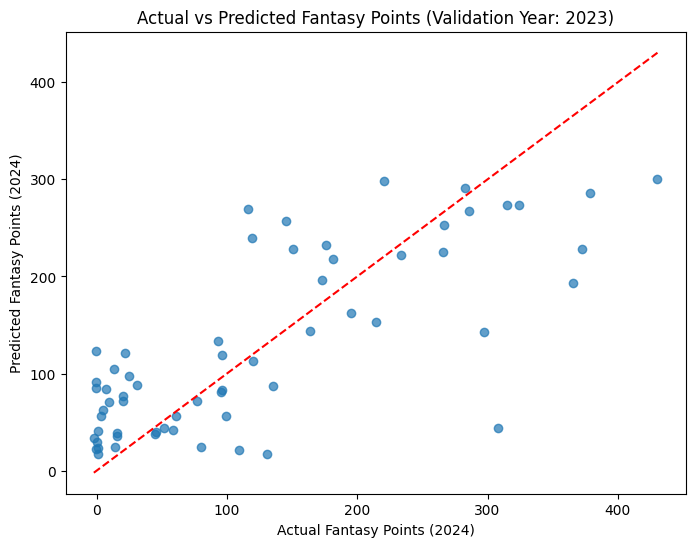

In [309]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


#### 2025 Predictions QBs

In [310]:
future_preds = model.predict(X_test)
QBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/4164295603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QBs_test['2025_Fantasy_Projection'] = future_preds


## RBs model

#### Creating Features

In [363]:
RBs = RBs.sort_values(['Player', 'Year'])

In [364]:
# Career Stats

RBs['Career_Att_Rush'] = RBs.groupby('Player')['Att_Rush'].cumsum().shift(1)
RBs['Career_Att_Rush'] = RBs['Career_Att_Rush'].fillna(0)

RBs['Career_Avg_PPR'] = RBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_PPR'] = RBs['Career_Avg_PPR'].fillna(0)

RBs['Career_Avg_Y/A'] = RBs.groupby('Player')['Y/A'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_Y/A'] = RBs['Career_Avg_Y/A'].fillna(0)

#Lagged Stats
RBs['Att_Rush_last_year'] = RBs.groupby('Player')['Att_Rush'].shift(1)

RBs['Yds_Rush_last_year'] = RBs.groupby('Player')['Yds (Rush)'].shift(1)

RBs['TD_last_year'] = RBs.groupby('Player')['TD'].shift(1)

RBs['Snaps_last_year'] = RBs.groupby('Player')['Total_Snaps'].shift(1)

RBs['Tgt_last_year'] = RBs.groupby('Player')['Tgt'].shift(1)

RBs['Rec_last_year'] = RBs.groupby('Player')['Rec'].shift(1)

RBs['Yds_rec_last_year'] = RBs.groupby('Player')['Yds_Rec'].shift(1)

#Lagged Fantasy Points for Testing
RBs['PPR_next_year'] = RBs.groupby('Player')['PPR'].shift(-1)
RBs_train = RBs[RBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
RBs_val = RBs[RBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
RBs_test = RBs[RBs['Year'] == 2024]

#### Creating Model

In [365]:
RBs_Features = ['Age', 'Att_Rush', 'Y/A', 'Yds (Rush)','Tgt', 'Rec', 'Yds_Rec','TD','Total_Snaps','Career_Att_Rush',
       'Career_Avg_PPR', 'Career_Avg_Y/A', 'Att_Rush_last_year',
       'Yds_Rush_last_year', 'TD_last_year', 'Snaps_last_year',
       'Tgt_last_year', 'Rec_last_year', 'Yds_rec_last_year']

X_train, y_train = RBs_train[RBs_Features], RBs_train['PPR_next_year']
X_val, y_val = RBs_val[RBs_Features], RBs_val['PPR_next_year']
X_test       = RBs_test[RBs_Features]

In [366]:
model = xgb.XGBRegressor(
    n_estimators = 350,
    learning_rate = 0.05,
    max_depth = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 50,
    reg_alpha = 1,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [367]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 54.073048518046136
Training R²: 0.6318408546299445
Validation RMSE: 69.96919581003245
Validation R²: 0.48301203791283365


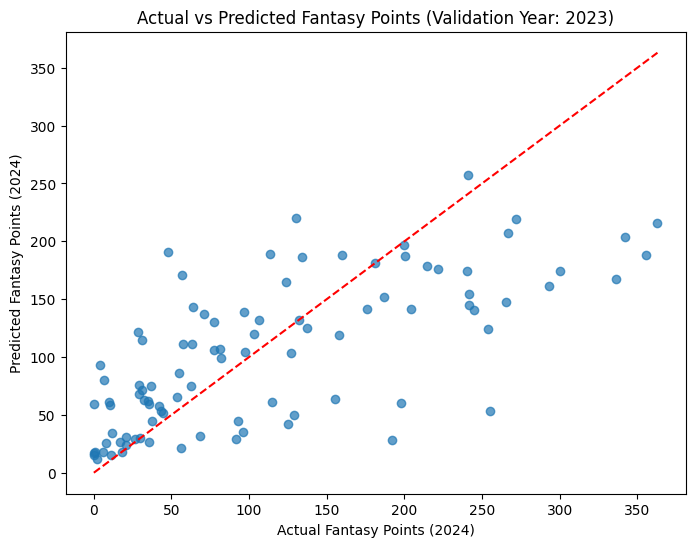

In [344]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


#### 2025 Predictions

In [368]:
future_preds = model.predict(X_test)
RBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/3481768187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RBs_test['2025_Fantasy_Projection'] = future_preds


## WRs Model

#### Creating Features

In [371]:
WRs = WRs.sort_values(['Player', 'Year'])

In [372]:
# Career Stats

WRs['Career_Tgt'] = WRs.groupby('Player')['Tgt'].cumsum().shift(1)
WRs['Career_Tgt'] = WRs['Career_Tgt'].fillna(0)

WRs['Career_Avg_PPR'] = WRs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_PPR'] = WRs['Career_Avg_PPR'].fillna(0)

WRs['Career_Avg_Yds_per_rec'] = WRs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_Yds_per_rec'] = WRs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
WRs['Att_Rush_last_year'] = WRs.groupby('Player')['Att_Rush'].shift(1)

WRs['Yds_Rush_last_year'] = WRs.groupby('Player')['Yds (Rush)'].shift(1)

WRs['TD_last_year'] = WRs.groupby('Player')['TD'].shift(1)

WRs['Snaps_last_year'] = WRs.groupby('Player')['Total_Snaps'].shift(1)

WRs['Tgt_last_year'] = WRs.groupby('Player')['Tgt'].shift(1)

WRs['Rec_last_year'] = WRs.groupby('Player')['Rec'].shift(1)

WRs['Yds_rec_last_year'] = WRs.groupby('Player')['Yds_Rec'].shift(1)

#Lagged Fantasy Points for Testing
WRs['PPR_next_year'] = WRs.groupby('Player')['PPR'].shift(-1)
WRs_train = WRs[WRs['Year'] < 2023].dropna(subset=['PPR_next_year'])
WRs_val = WRs[WRs['Year'] == 2023].dropna(subset=['PPR_next_year'])
WRs_test = WRs[WRs['Year'] == 2024]

In [170]:
WRs.columns

Index(['Player', 'Tm', 'Age', 'G', 'GS', 'Att_Rush', 'Yds (Rush)', 'Y/A',
       'TD (Rush)', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec', 'TD (Rec)', 'Fmb',
       'FL', 'TD', '2PM', '2PP', 'PPR', 'Total_Snaps', 'Avg Snaps',
       'TM SNAP %', 'PPR_Rush', 'PPR_RushAtt', 'Tot_PPR_Rec', 'PPR_Tgt',
       'Tgt_gm', 'PPR_Rec', 'PPR_Snap', 'Year', 'PPR_Yards_Only', 'Career_Tgt',
       'Career_Att_Rush', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
       'Att_Rush_last_year', 'Yds_Rush_last_year', 'TD_last_year',
       'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year',
       'Yds_rec_last_year', 'PPR_next_year'],
      dtype='object')

#### Creating the model

In [373]:
WRs_Features = ['Age', 'Att_Rush', 'Yds (Rush)', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD','Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Att_Rush_last_year', 'Yds_Rush_last_year', 'TD_last_year',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year']

X_train, y_train = WRs_train[WRs_Features], WRs_train['PPR_next_year']
X_val, y_val = WRs_val[WRs_Features], WRs_val['PPR_next_year']
X_test       = WRs_test[WRs_Features]

In [378]:
model = xgb.XGBRegressor(
    n_estimators = 150,
    learning_rate = 0.05,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 50,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [379]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 44.093130381175726
Training R²: 0.7386908681892828
Validation RMSE: 57.26734501491484
Validation R²: 0.5461300776305809


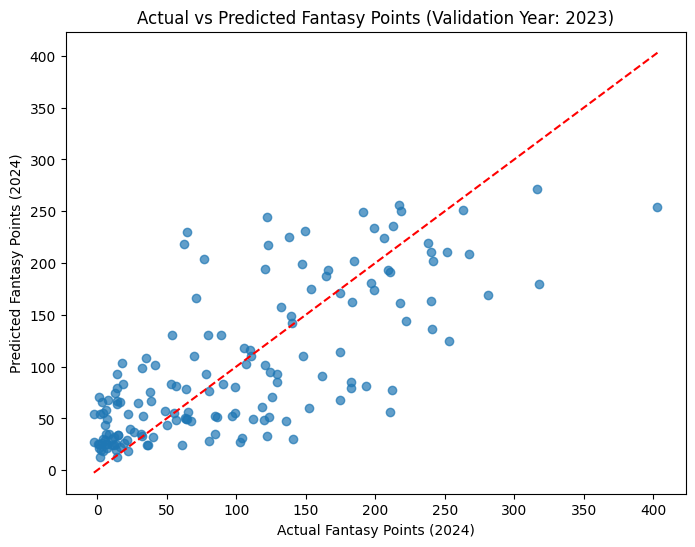

In [224]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

#### 2025 Predictions

In [380]:
future_preds = model.predict(X_test)
WRs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/1016118979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs_test['2025_Fantasy_Projection'] = future_preds


## TEs Model

## Creating Features

In [390]:
TEs = TEs.sort_values(['Player', 'Year'])

In [391]:
# Career Stats

TEs['Career_Tgt'] = TEs.groupby('Player')['Tgt'].cumsum().shift(1)
TEs['Career_Tgt'] = TEs['Career_Tgt'].fillna(0)

TEs['Career_Avg_PPR'] = TEs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_PPR'] = TEs['Career_Avg_PPR'].fillna(0)

TEs['Career_Avg_Yds_per_rec'] = TEs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_Yds_per_rec'] = TEs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
TEs['Att_Rush_last_year'] = TEs.groupby('Player')['Att_Rush'].shift(1)

TEs['Yds_Rush_last_year'] = TEs.groupby('Player')['Yds (Rush)'].shift(1)

TEs['TD_last_year'] = TEs.groupby('Player')['TD'].shift(1)

TEs['Snaps_last_year'] = TEs.groupby('Player')['Total_Snaps'].shift(1)

TEs['Tgt_last_year'] = TEs.groupby('Player')['Tgt'].shift(1)

TEs['Rec_last_year'] = TEs.groupby('Player')['Rec'].shift(1)

TEs['Yds_rec_last_year'] = TEs.groupby('Player')['Yds_Rec'].shift(1)

#Lagged Fantasy Points for Testing
TEs['PPR_next_year'] = TEs.groupby('Player')['PPR'].shift(-1)
TEs_train = TEs[TEs['Year'] < 2023].dropna(subset=['PPR_next_year'])
TEs_val = TEs[TEs['Year'] == 2023].dropna(subset=['PPR_next_year'])
TEs_test = TEs[TEs['Year'] == 2024]

In [392]:
TEs_Features = ['Age', 'Att_Rush', 'Yds (Rush)', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD','Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Att_Rush_last_year', 'Yds_Rush_last_year', 'TD_last_year',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year']

X_train, y_train = TEs_train[TEs_Features], TEs_train['PPR_next_year']
X_val, y_val = TEs_val[TEs_Features], TEs_val['PPR_next_year']
X_test       = TEs_test[TEs_Features]

#### Creating the model

In [393]:
model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 20,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [394]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 38.904627972128445
Training R²: 0.6094354676901476
Validation RMSE: 44.08600906314138
Validation R²: 0.48514016092240053


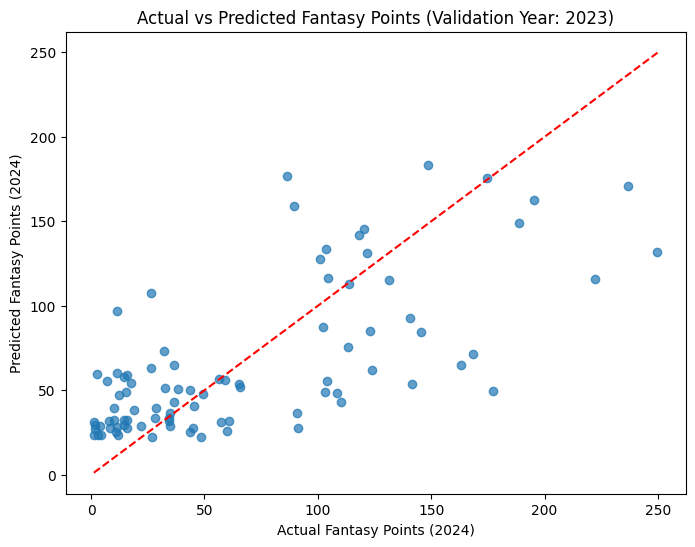

In [272]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

#### 2025 Predictions TEs

In [395]:
future_preds = model.predict(X_test)
TEs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/1835647429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEs_test['2025_Fantasy_Projection'] = future_preds


In [360]:
QBs_test['Pos'] = 'QB'
RBs_test['Pos'] = 'RB'
WRs_test['Pos'] = 'WR'
TEs_test['Pos'] = 'TE'

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QBs_test['Pos'] = 'QB'
/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RBs_test['Pos'] = 'RB'
/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [396]:
all_players = pd.concat([RBs_test, WRs_test, TEs_test], ignore_index=True)

In [370]:
RBs_test[RBs_test['Player'] == "JAVONTE WILLIAMS"]

,Player,Tm,Age,G,GS,Att_Rush,Yds (Rush),Y/A,TD (Rush),Tgt,Rec,Yds_Rec,Yds_per_rec,TD (Rec),Fmb,FL,TD,2PM,2PP,PPR,Total_Snaps,Avg Snaps,TM SNAP %,PPR_Rush,PPR_RushAtt,Tot_PPR_Rec,PPR_Tgt,Tgt_gm,PPR_Rec,PPR_Snap,Year,Career_Att_Rush,Career_Avg_PPR,Career_Avg_Y/A,Att_Rush_last_year,Yds_Rush_last_year,TD_last_year,Snaps_last_year,Tgt_last_year,Rec_last_year,Yds_rec_last_year,PPR_next_year,2025_Fantasy_Projection
32,JAVONTE WILLIAMS,DEN,24.0,17.0,11.0,139.0,513.0,3.69,4.0,70.0,52.0,346.0,6.65,0.0,2.0,2.0,4.0,0.0,0.0,157.9,574,33,52.1,75.3,0.541727,86.6,1.237143,4.117647,1.665385,0.275087,2024,467.0,142.033333,4.12,217.0,774.0,5.0,493.0,58.0,47.0,228.0,NaN,152.959457
